# Python para Ciência de Dados
## Análise do Desenvolvimento Humano e Econômico Global com Base no Dataset Gapminder

Técnicas utilizadas
- Separação de dados em níveis de qualidade de dados (bronze, prata, ouro): Organizando dados já processados
- Uso de backward-fill e interpolação linear: Processamento de dados ausentes


Datasets adicionais e Fontes de Dados
- Códigos ISO:
- Mortalidade Infantil:
- Emissões de CO2
- Consumo de proteína:
- Alfabetização:


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
from io import StringIO
from enum import Enum

df = pd.read_csv('dados/bronze/gapminder_full.csv', sep=',')

### Descrições Iniciais do Dataset - Sem limpeza

In [5]:
df.head()

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1736 non-null   object 
 1   year       1736 non-null   int64  
 2   pop        1736 non-null   float64
 3   continent  1736 non-null   object 
 4   lifeExp    1736 non-null   float64
 5   gdpPercap  1736 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 81.5+ KB


In [7]:
df.describe()

,year,pop,lifeExp,gdpPercap
count,1736.000000,1.736000e+03,1736.000000,1736.000000
mean,1979.669931,3.156800e+07,59.511979,7240.155986
std,17.296364,1.172888e+08,12.956028,9839.873695
min,1952.000000,6.001100e+04,23.599000,241.165876
25%,1967.000000,2.818694e+06,48.245000,1202.060309
50%,1982.000000,7.150606e+06,60.808000,3534.772106
75%,1997.000000,1.977102e+07,70.945000,9380.254270
max,2007.000000,1.318683e+09,82.603000,113523.132900


## Análise e limpeza dos datasets

In [8]:
size_country = df.groupby("country").size().sort_values(ascending=False)
size_country

country
France                19
Bolivia               17
Guinea                17
Ecuador               15
China                 15
                      ..
Vietnam               12
West Bank and Gaza    12
Yemen Rep.            12
Zambia                12
Zimbabwe              12
Length: 142, dtype: int64

Temos valores duplicados em nosso dataset os paises deviam ter apenas 12 entradas, precisamos limpar os valores duplicados

In [9]:
df = df.drop_duplicates() # Estamos removendo duplicatas completas
# Verificando se há algum registro duplicado restante, usando subset de pais e ano
duplicados_restantes = df[df.duplicated(subset=['country', 'year'], keep= False)].copy()
duplicados_restantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    0 non-null      object 
 1   year       0 non-null      int64  
 2   pop        0 non-null      float64
 3   continent  0 non-null      object 
 4   lifeExp    0 non-null      float64
 5   gdpPercap  0 non-null      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 0.0+ bytes


Foram removidos 32 registros duplicados (duplicatas completas)... Não há mais nenhum registro duplicado restante

Agora queremos verificar se os registros por ano estão distribuídos uniformente

In [10]:
df_analise_agrupamento_anoxpais = df.sort_values(["country", "year"])
df_analise_agrupamento_anoxpais["diff_ano"] = df.groupby("country")["year"].diff().fillna(0).astype(int)
df_analise_agrupamento_anoxpais

,country,year,pop,continent,lifeExp,gdpPercap,diff_ano
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,0
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,5
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,5
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,5
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,5
...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,5
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,5
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,5
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,5


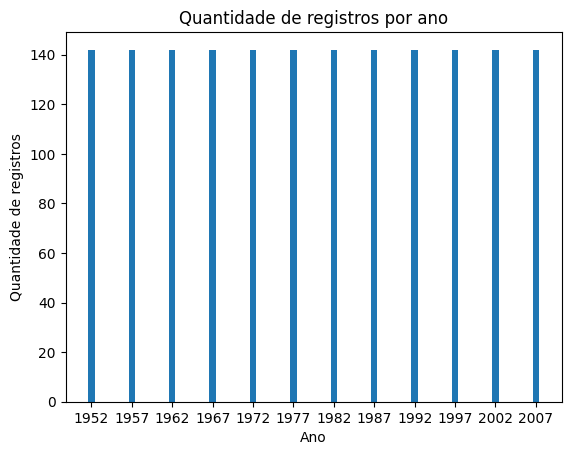

In [11]:
count_por_ano = df_analise_agrupamento_anoxpais.groupby("year").size().reset_index(name="total")
plt.figure()
plt.bar(count_por_ano["year"], count_por_ano["total"])
plt.xlabel("Ano")
plt.ylabel("Quantidade de registros")
plt.title("Quantidade de registros por ano")
plt.xticks(count_por_ano["year"])
plt.show()

Os registros estão distribuídos uniformemente com registros a cada 5 anos... 

Verificando existência de dados ausentes

In [12]:
df.isnull().sum()

country      0
year         0
pop          0
continent    0
lifeExp      0
gdpPercap    0
dtype: int64

Não há nenhum dado ausente em nosso data set - vamos salvar uma versão limpa dos dados

In [13]:
df.to_csv("dados/prata/gapminder_dataset_limpo.csv", sep='|', encoding='utf-8')

## Criando novas colunas - derivando dados

In [14]:
df["gdp_total"] = df["pop"] * df["gdpPercap"]
df["gdp_total_bn"] = df["gdp_total"] / 1_000_000_000
df["pop_mn"] = df["pop"] / 1_000_000
df

,country,year,pop,continent,lifeExp,gdpPercap,gdp_total,gdp_total_bn,pop_mn
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,6.567086e+09,6.567086,8.425333
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,7.585449e+09,7.585449,9.240934
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,8.758856e+09,8.758856,10.267083
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,9.648014e+09,9.648014,11.537966
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,9.678553e+09,9.678553,13.079460
...,...,...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,6.508241e+09,6.508241,9.216418
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,7.422612e+09,7.422612,10.704340
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,9.037851e+09,9.037851,11.404948
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,8.015111e+09,8.015111,11.926563


## Obtendo dados de fontes externas

### Definição de funções

In [18]:
def load_csv_columns(url, path, columns):
    """
    Baixa um CSV a partir de uma URL, valida colunas, salva o arquivo completo
    e retorna apenas as colunas selecionadas.

    Parâmetros:
        url (str): Endereço do CSV na web.
        path (str): Caminho onde o CSV completo será salvo.
        columns (list): Lista de colunas que devem ser retornadas.

    Retorna:
        DataFrame contendo apenas as colunas solicitadas.
    """

    # -----------------------------
    # 1. Validação básica da URL
    # -----------------------------
    if not isinstance(url, str) or not url.startswith(("http://", "https://")):
        raise ValueError("A URL fornecida é inválida ou não começa com http/https.")

    # -----------------------------
    # 2. Tentativa de download
    # -----------------------------
    try:
        response = requests.get(url, timeout=10)  # timeout evita travamentos
        response.raise_for_status()  # lança erro se status != 200
    except requests.exceptions.Timeout:
        raise TimeoutError("A requisição excedeu o tempo limite.")
    except requests.exceptions.HTTPError as e:
        raise ConnectionError(f"Erro HTTP ao acessar a URL: {e}")
    except requests.exceptions.RequestException as e:
        raise ConnectionError(f"Erro ao tentar baixar o arquivo: {e}")

    # -----------------------------
    # 3. Leitura do CSV em memória
    # -----------------------------
    try:
        df = pd.read_csv(StringIO(response.text))
    except Exception as e:
        raise ValueError(f"Erro ao ler o CSV: {e}")

    # -----------------------------
    # 4. Validação das colunas
    # -----------------------------
    colunas_faltando = [c for c in columns if c not in df.columns]
    if colunas_faltando:
        raise KeyError(f"As seguintes colunas não existem no CSV: {colunas_faltando}")

    # -----------------------------
    # 5. Seleção das colunas desejadas
    # -----------------------------
    df_filtrado = df[columns].reset_index(drop=True)

    # -----------------------------
    # 6. Criar diretório se não existir
    # -----------------------------
    os.makedirs(os.path.dirname(path), exist_ok=True)

    # -----------------------------
    # 7. Salvar o CSV completo no disco
    # -----------------------------
    try:
        df.to_csv(path, sep=';', encoding='utf-8', index=False)
    except Exception as e:
        raise IOError(f"Erro ao salvar o arquivo no caminho especificado: {e}")

    # -----------------------------
    # 8. Retornar apenas as colunas filtradas
    # -----------------------------
    return df_filtrado

def preencher_dataframe_por_interpolacao_linear(df, coluna_valor="child_mortality"):
    """
    Preenche anos faltantes e realiza interpolação linear sobre uma coluna numérica.

    Parâmetros:
        df (DataFrame): DataFrame contendo pelo menos 'year', 'country' e a coluna numérica.
        coluna_valor (str): Nome da coluna numérica a ser interpolada.

    Retorna:
        DataFrame com anos completos, país preenchido e valores interpolados.
    """

    # -----------------------------
    # 1. Validação básica
    # -----------------------------
    colunas_necessarias = {"year", "country", coluna_valor}
    faltando = colunas_necessarias - set(df.columns)

    if faltando:
        raise KeyError(f"Colunas faltando no DataFrame: {faltando}")

    # -----------------------------
    # 2. Ordenar por ano
    # -----------------------------
    df = df.sort_values("year").reset_index(drop=True)

    # -----------------------------
    # 3. Criar intervalo completo de anos
    # -----------------------------
    anos_completos = pd.DataFrame({
        "year": range(df["year"].min(), df["year"].max() + 1)
    })

    # -----------------------------
    # 4. Fazer merge para incluir anos faltantes
    # -----------------------------
    df = anos_completos.merge(df, on="year", how="left")

    # -----------------------------
    # 5. Preencher país (forward fill + backward fill)
    # -----------------------------
    df["country"] = df["country"].ffill().bfill()

    # -----------------------------
    # 6. Interpolação linear da coluna numérica
    # -----------------------------
    df[coluna_valor] = (
        df[coluna_valor]
        .interpolate(method="linear")  # preenche valores intermediários
        .bfill()                       # garante que o início não fique nulo
        .ffill()                       # garante que o fim não fique nulo
    )

    return df 

### Código ISO dos Países (Chave Primária para outros datasets)

In [19]:
iso_countries = load_csv_columns(
    "https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv", 
    "dados/bronze/contry_iso_codes.csv", 
    ["COUNTRY", "CODE"]
)
# Renomeando colunas para padrão gapminder
iso_countries = iso_countries.rename(columns={
    "COUNTRY": "country",
    "CODE": "code"
})

iso_countries

,country,code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
...,...,...
217,Virgin Islands,VGB
218,West Bank,WBG
219,Yemen,YEM
220,Zambia,ZMB


### ETL de dados de mortalidade infantil

In [20]:
child_mortality = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/6155d4ca1ea14ef30e753010a25521eeb416e8a2/datasets/Child%20mortality%20-%20Gapminder%20(2013)/Child%20mortality%20-%20Gapminder%20(2013).csv",
    "dados/bronze/child_mortality.csv",
    ["Entity", "Year", "Child mortality (Gapminder (2013))"]
)
# Renomeando colunas para padrão gapminder
child_mortality = child_mortality.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Child mortality (Gapminder (2013))" : "child_mortality"
})
# Preenchendo valores faltantes por interpolação linear
child_mortality = preencher_dataframe_por_interpolacao_linear(child_mortality).sort_values(by=['country', 'year'])
# Organizando o DataFrame final, aplicando a função por país
child_mortality = (
    child_mortality
    .groupby("country", group_keys=False)
    .apply(preencher_dataframe_por_interpolacao_linear)
    .sort_values(["country", "year"])
    .reset_index(drop=True)
)

child_mortality.to_csv("dados/prata/child_mortality.csv", sep=';', encoding='utf-8', index=False)

C:\Users\nelyo\AppData\Local\Temp\ipykernel_8288\3738842109.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(preencher_dataframe_por_interpolacao_linear)


### ETL de Share de Emissões de CO2

In [21]:
co2_share = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Cumulative%20CO2%20emissions%20share%20(OWID%20based%20on%20GCP%2C%202017)/Cumulative%20CO2%20emissions%20share%20(OWID%20based%20on%20GCP%2C%202017).csv",
    "dados/bronze/co2_emissions.csv",
    ["Entity", "Year", "Cumulative CO2 emissions share (OWID based on GCP, 2017)"]
)
# Renomeando colunas para padrão gapminder
co2_share = co2_share.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Cumulative CO2 emissions share (OWID based on GCP, 2017)" : "co2_share"
})

co2_share.to_csv("dados/prata/co2_emissions.csv", sep=';', encoding='utf-8', index=False)

### ETL de Consumo de Proteína

In [22]:
protein_consumption = load_csv_columns(
   "https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Daily%20protein%20supply%20-%20FAO%20(2017)/Daily%20protein%20supply%20-%20FAO%20(2017).csv",
    "dados/bronze/protein_consumption.csv",
    ["Entity", "Year", "Daily protein supply (FAO (2017))", "Daily protein supply of animal origin (FAO (2017))", "Daily protein supply of plant origin (FAO (2017))", "Share of protein of animal origin (FAO (2017))", "Share of protein of plant origin (FAO (2017))"]
)

protein_consumption = protein_consumption.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Daily protein supply (FAO (2017))" : "daily_protein_consumption"
})

### ETL de Alfabetização

In [23]:
literacy = load_csv_columns(
    "https://raw.githubusercontent.com/owid/owid-datasets/refs/heads/master/datasets/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources/Cross-country%20literacy%20rates%20-%20World%20Bank%2C%20CIA%20World%20Factbook%2C%20and%20other%20sources.csv",
    "dados/bronze/literacy_rate.csv",
    ["Entity", "Year", "Literacy rates (World Bank, CIA World Factbook, and other sources)"]
)

literacy = literacy.rename(columns={
    "Entity" : "country",
    "Year" : "year",
    "Literacy rates (World Bank, CIA World Factbook, and other sources)" : "literacy_rate"
})

literacy

,country,year,literacy_rate
0,Afghanistan,1979,18.157681
1,Afghanistan,2011,31.741119
2,Afghanistan,2015,38.168041
3,Albania,2001,98.712982
4,Albania,2008,95.938637
...,...,...,...
1418,Zambia,2015,85.117264
1419,Zimbabwe,1982,77.794167
1420,Zimbabwe,1992,83.512581
1421,Zimbabwe,2011,83.582710


### Merge dos dados e persistência

In [24]:
df_code = df.merge(iso_countries[["code", "country"]], on=["country"], how="left")
df_cm = df_code.merge(child_mortality[["child_mortality", "year", "country"]], on=["country", "year"], how="left")
df_cm = df_cm.merge(co2_share[["co2_share", "year", "country"]], on=["country", "year"], how="left")
df_cm = df_cm.merge(protein_consumption[["daily_protein_consumption", "year", "country"]], on=["country", "year"], how="left")
df_cm = df_cm.merge(literacy[["literacy_rate", "year", "country"]], on=["country", "year"], how="left")
df_cm.to_csv("dados/ouro/dados_consolidados.csv", sep=';', encoding='utf-8', index=False)
df_cm

,country,year,pop,continent,lifeExp,gdpPercap,code,child_mortality,co2_share,daily_protein_consumption,literacy_rate
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314,AFG,422.433333,0.0001,NaN,NaN
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030,AFG,376.100000,0.0004,NaN,NaN
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710,AFG,348.600000,0.0011,82.98,NaN
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138,AFG,323.700000,0.0022,85.25,NaN
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106,AFG,299.000000,0.0034,75.75,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1731,Zimbabwe,1987,9216418.0,Africa,62.351,706.157306,ZWE,74.000000,0.0450,50.24,NaN
1732,Zimbabwe,1992,10704340.0,Africa,60.377,693.420786,ZWE,81.600000,0.0486,49.10,83.512581
1733,Zimbabwe,1997,11404948.0,Africa,46.809,792.449960,ZWE,100.700000,0.0509,46.92,NaN
1734,Zimbabwe,2002,11926563.0,Africa,39.989,672.038623,ZWE,100.300000,0.0514,46.66,NaN


In [37]:
# Substituir nomes dos países pelos códigos ISO
df_cm['country'] = df_cm['code']

### Modularização dos gráficos

In [25]:
def grafico_barras_horizontais(dataframe, eixo_x, eixo_y, titulo):
    # Cria uma nova figura com tamanho definido
    plt.figure(figsize=(10, 6))
    
    # Cria um gráfico de barras horizontais usando seaborn
    sns.barplot(data=dataframe, x=eixo_x, y=eixo_y)
    
    # Define o título do gráfico
    plt.title(titulo)
    
    # Ajusta o limite do eixo X (opcional, aqui focando entre 70 e 90)
    plt.xlim(70, 90)
    
    # Exibe o gráfico
    plt.show()


def grafico_linha_marcadores(dataframe, eixo_x, eixo_y, titulo, label_y=""):
    # Cria uma nova figura com tamanho definido
    plt.figure(figsize=(10, 6))
    
    # Cria um gráfico de linha com marcadores circulares
    sns.lineplot(data=dataframe, x=eixo_x, y=eixo_y, marker='o')
    
    # Define o título do gráfico
    plt.title(titulo)
    
    # Define o rótulo do eixo Y (caso seja fornecido)
    plt.ylabel(label_y)
    
    # Exibe o gráfico
    plt.show()


def grafico_boxplot(dataframe, eixo_x, eixo_y, titulo):
    # Cria uma nova figura com tamanho definido
    plt.figure(figsize=(10, 6))
    
    # Cria um boxplot para visualizar distribuição e outliers
    sns.boxplot(data=dataframe, x=eixo_x, y=eixo_y)
    
    # Define o título do gráfico
    plt.title(titulo)
    
    # Exibe o gráfico
    plt.show()


def grafico_barras_correlacao(dataframe, alvo, metodo="pearson"):
    # Seleciona apenas colunas numéricas para calcular correlação
    df_num = dataframe.select_dtypes(include="number")
    
    # Calcula a matriz de correlação usando o método escolhido
    corr = df_num.corr(method=metodo)
    
    # Se um alvo for fornecido, plota apenas a correlação com essa variável
    if alvo:
        # Ordena as correlações e plota como barras horizontais
        corr[alvo].sort_values().plot.barh(figsize=(6, 4))
        
        # Título e rótulos
        plt.title(f"Correlação com {alvo}")
        plt.xlabel("Correlação")
        
        # Ajusta layout para evitar sobreposição
        plt.tight_layout()
        plt.show()
        return
    
    # Caso nenhum alvo seja fornecido, plota a matriz completa
    plt.figure(figsize=(8, 6))
    
    # Exibe a matriz como imagem (heatmap simples)
    plt.imshow(corr)
    plt.colorbar()  # Barra de cores indicando intensidade da correlação
    
    # Define rótulos dos eixos com os nomes das colunas
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    
    # Título do gráfico
    plt.title("Matriz de Correlação")
    
    # Ajusta layout
    plt.tight_layout()
    plt.show()


def grafico_matriz_correlacao(dataframe, metodo="pearson"):
    # Seleciona apenas colunas numéricas
    df_num = dataframe.select_dtypes(include="number")
    
    # Calcula a matriz de correlação
    corr = df_num.corr(method=metodo)
    
    # Cria figura
    plt.figure(figsize=(8, 6))
    
    # Exibe a matriz como imagem (heatmap simples)
    plt.imshow(corr)
    
    # Barra de cores indicando intensidade da correlação
    plt.colorbar(label="Correlação")
    
    # Rótulos dos eixos
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    
    # Título do gráfico
    plt.title(f"Matriz de Correlação ({metodo})")
    
    # Ajusta layout
    plt.tight_layout()
    plt.show()

### Modularização de Filtros

In [26]:
def filtrar_por_ano(dataframe, ano):
    return dataframe[dataframe['year'] == ano].copy()

def filtrar_por_periodo(dataframe, ano_inicio, ano_fim):
    return dataframe[(dataframe["year"] >= ano_inicio) & (dataframe["year"] <= ano_fim)].copy()

def filtrar_por_continente(dataframe, continente):
    return dataframe[dataframe['continent'] == continente].copy()

def filtrar_por_iso_code(dataframe, iso_code):
    return dataframe[dataframe['code'] == iso_code].copy()

def filtrar_por_paises(df, paises):
    return df[df["country"].isin(paises)].copy()

class Continente(Enum):
    ASIA = "Asia"
    AFRICA = "Africa"
    EUROPA = "Europe"
    AMERICA = "Americas"
    OCEANIA = "Oceania"


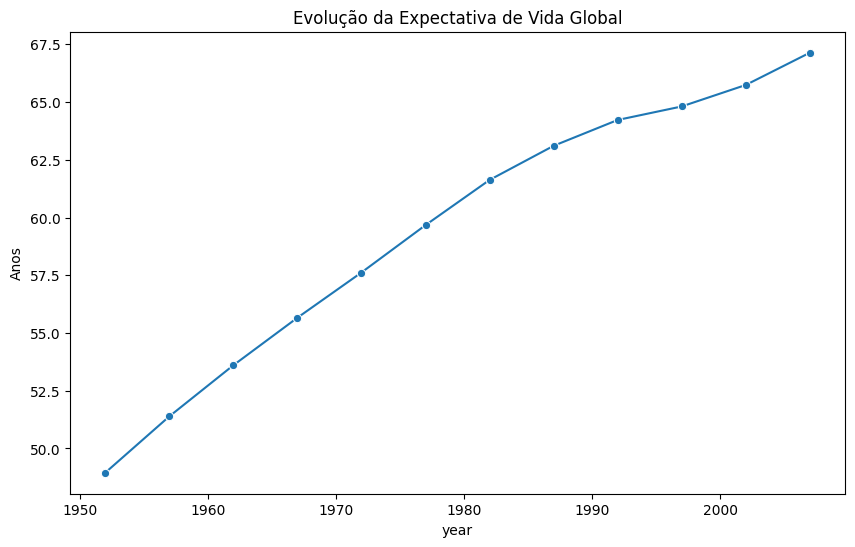

In [27]:
media_ano = df.groupby('year')['lifeExp'].mean().reset_index()
#media_ano = filtrar_por_continente(df_cm, Continente.OCEANIA.value)
#media_ano = filtrar_por_iso_code(df_cm, "USA")
grafico_linha_marcadores(media_ano, 'year', 'lifeExp', 'Evolução da Expectativa de Vida Global', 'Anos')

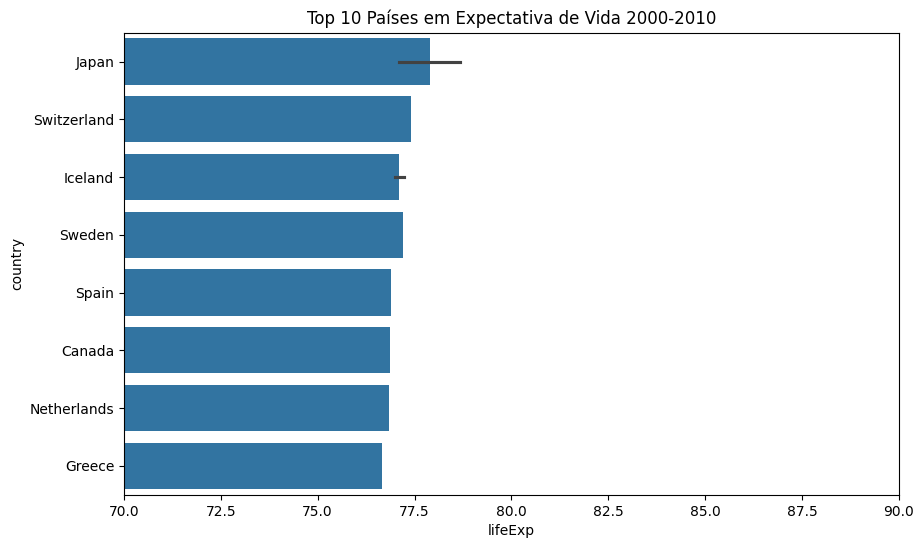

In [28]:
df_ano = filtrar_por_periodo(df_cm, 1980, 1990)
top10 = df_ano.nlargest(10, 'lifeExp')
grafico_barras_horizontais(top10, 'lifeExp', 'country', 'Top 10 Países em Expectativa de Vida 2000-2010')

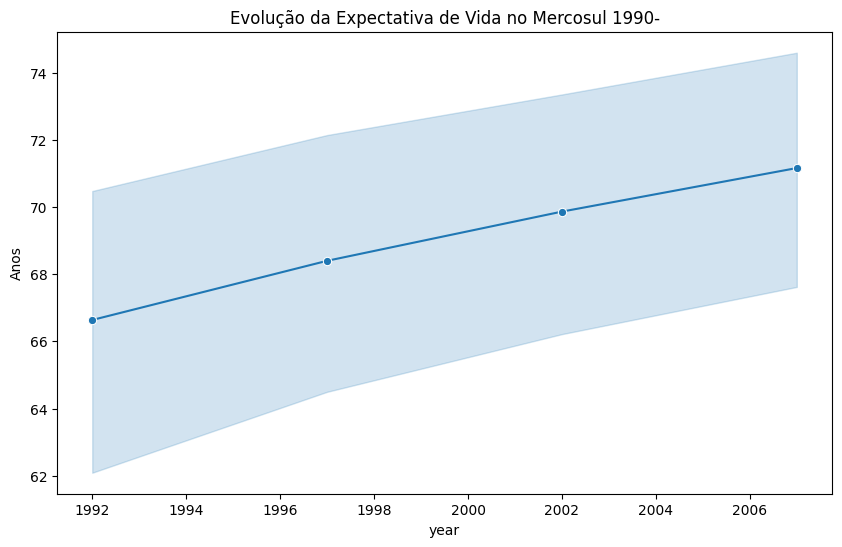

In [29]:
paises = ["Brazil", "Argentina", "Paraguay", "Uruguay", "Bolivia"]
df_filtrado = filtrar_por_paises(df_cm, paises)
df_filtrado = filtrar_por_periodo(df_filtrado, 1990, 2010)
grafico_linha_marcadores(df_filtrado, 'year', 'lifeExp', 'Evolução da Expectativa de Vida no Mercosul 1990-', 'Anos')

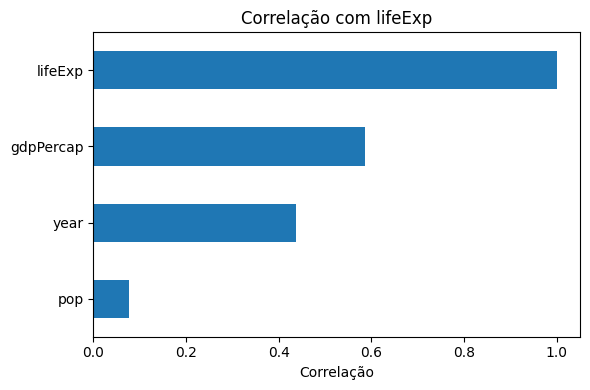

In [30]:
grafico_barras_correlacao(df, alvo="lifeExp")

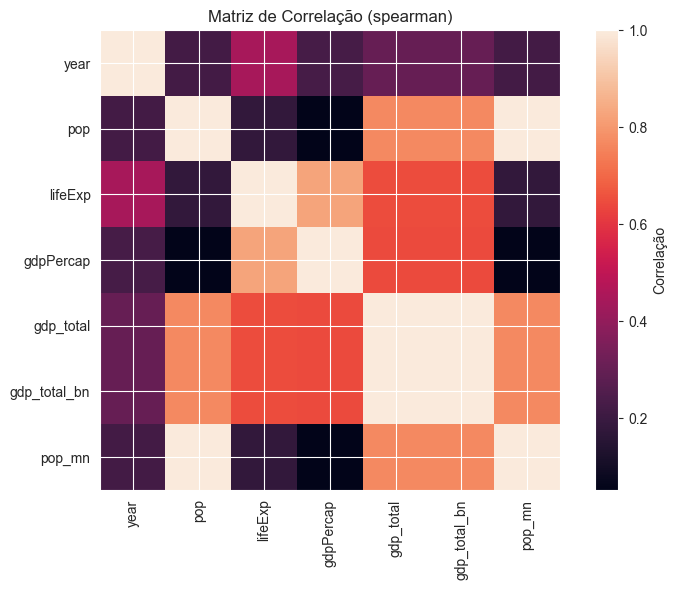

In [44]:
grafico_matriz_correlacao(df, metodo="spearman")

# Opções - Mundial

- Fazer a linha média mundial de alguma coisa e a linha média por país
- Países com maior crescimento de expectativa de vida no periodo (Por década)
- Países com maior decrescimo de expectativa de vida no periodo (Por década)
- Análise de Tendência de expectativa de vida mundial
- Análise por continente
- Top 10


# Brasil
- Análise de tendência de expectativa de vida (Precisa complementar os dados)
- Análise de tentência de crescimento de PIB (Precisa complementar os dados)
- Correlação entre crescimento do emprego com a expectativa de vida

- derivar variaveis

Dimensões:
- Mundial
- Por continente
- Brasil
- Mercosul

Desenvolvimento:
- Humano
- Economico-Tecnológico

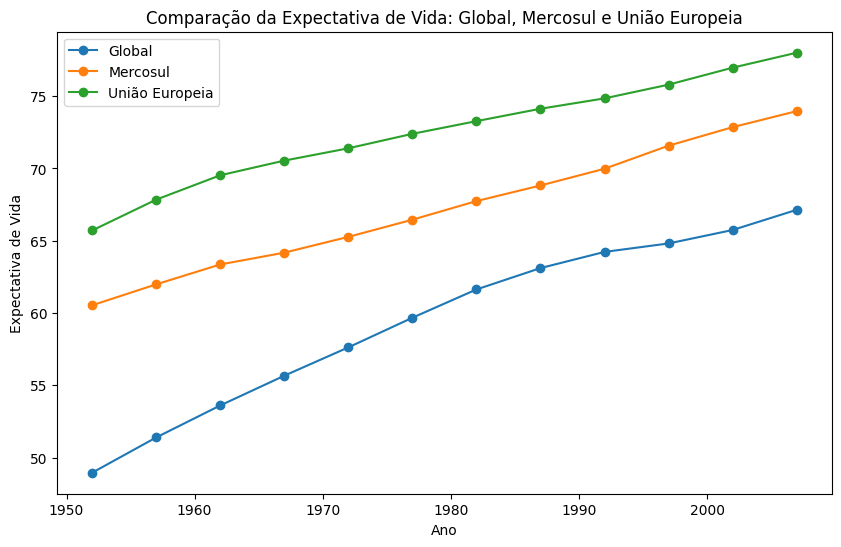

In [38]:
paises_mercosul = ["BRA", "ARG", "PRY", "URY"]
paises_eu = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]
df_mercosul = filtrar_por_paises(df_cm, paises_mercosul)
df_eu = filtrar_por_paises(df_cm, paises_eu)
media_global = df_cm.groupby('year')['lifeExp'].mean().reset_index()
media_mercosul = df_mercosul.groupby('year')['lifeExp'].mean().reset_index()
media_eu = df_eu.groupby('year')['lifeExp'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(media_global['year'], media_global['lifeExp'], label='Global', marker='o')
plt.plot(media_mercosul['year'], media_mercosul['lifeExp'], label='Mercosul', marker='o')
plt.plot(media_eu['year'], media_eu['lifeExp'], label='União Europeia', marker='o')
plt.title('Comparação da Expectativa de Vida: Global, Mercosul e União Europeia')
plt.xlabel('Ano')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.show()

In [ ]:
grafico_linha_marcadores(media_eu, 'year', 'lifeExp', 'Evolução da Expectativa de Vida na União Europeia', 'Anos')

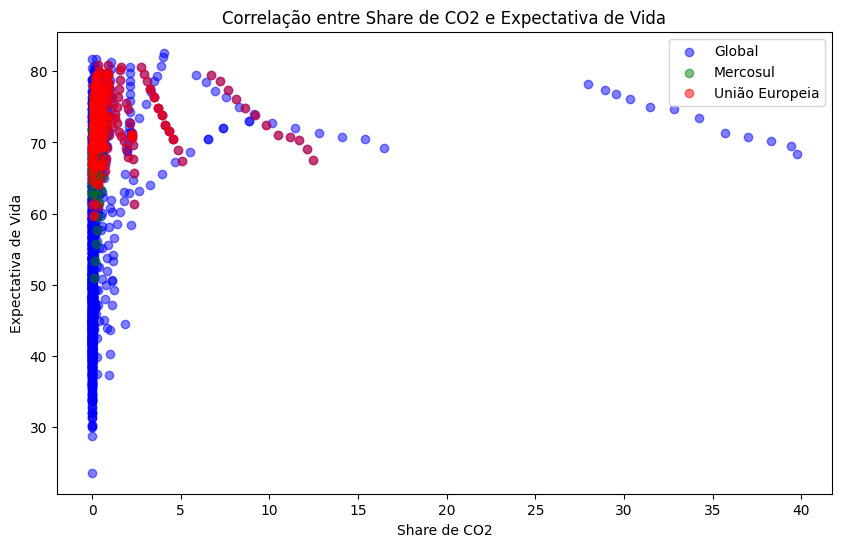

In [34]:
# Gráfico de correlação: CO2 vs Expectativa de Vida
plt.figure(figsize=(10, 6))
plt.scatter(df_cm['co2_share'], df_cm['lifeExp'], label='Global', alpha=0.5, color='blue')
plt.scatter(df_mercosul['co2_share'], df_mercosul['lifeExp'], label='Mercosul', alpha=0.5, color='green')
plt.scatter(df_eu['co2_share'], df_eu['lifeExp'], label='União Europeia', alpha=0.5, color='red')
plt.title('Correlação entre Share de CO2 e Expectativa de Vida')
plt.xlabel('Share de CO2')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.show()

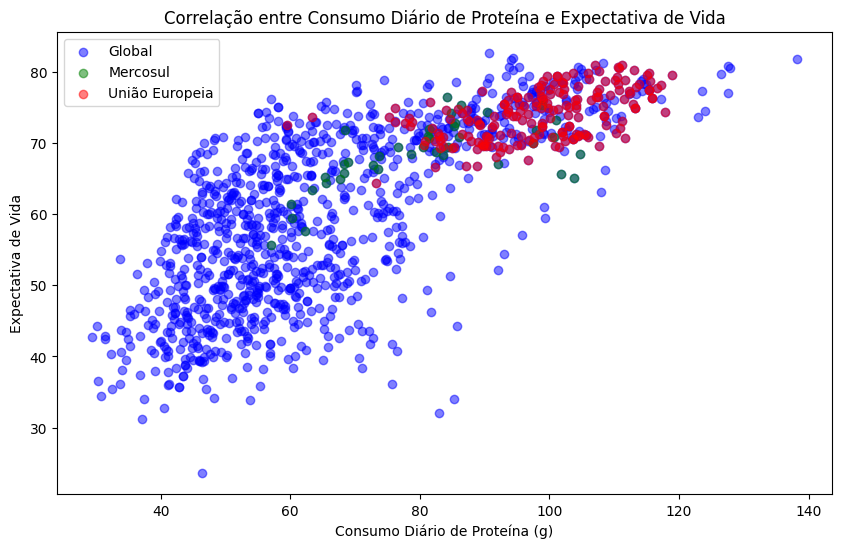

In [35]:
# Gráfico de correlação: Consumo de Proteína vs Expectativa de Vida
plt.figure(figsize=(10, 6))
plt.scatter(df_cm['daily_protein_consumption'], df_cm['lifeExp'], label='Global', alpha=0.5, color='blue')
plt.scatter(df_mercosul['daily_protein_consumption'], df_mercosul['lifeExp'], label='Mercosul', alpha=0.5, color='green')
plt.scatter(df_eu['daily_protein_consumption'], df_eu['lifeExp'], label='União Europeia', alpha=0.5, color='red')
plt.title('Correlação entre Consumo Diário de Proteína e Expectativa de Vida')
plt.xlabel('Consumo Diário de Proteína (g)')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.show()

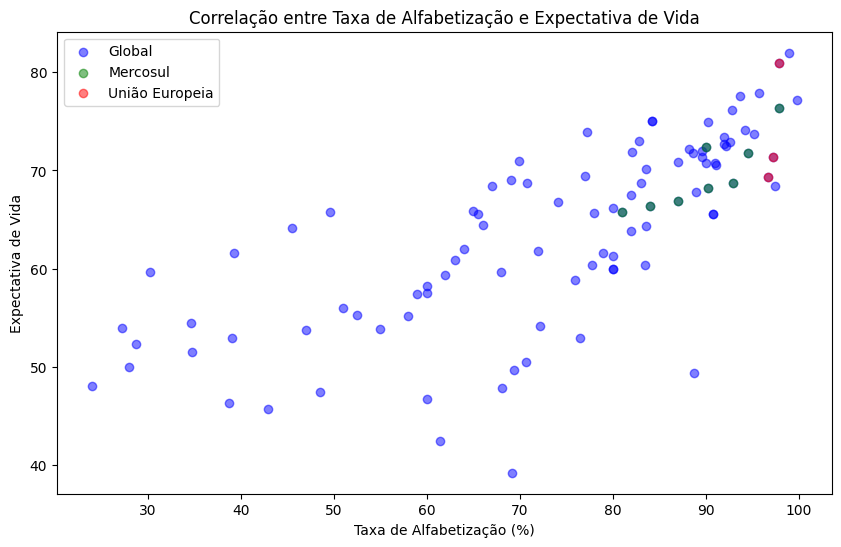

In [36]:
# Gráfico de correlação: Taxa de Alfabetização vs Expectativa de Vida
plt.figure(figsize=(10, 6))
plt.scatter(df_cm['literacy_rate'], df_cm['lifeExp'], label='Global', alpha=0.5, color='blue')
plt.scatter(df_mercosul['literacy_rate'], df_mercosul['lifeExp'], label='Mercosul', alpha=0.5, color='green')
plt.scatter(df_eu['literacy_rate'], df_eu['lifeExp'], label='União Europeia', alpha=0.5, color='red')
plt.title('Correlação entre Taxa de Alfabetização e Expectativa de Vida')
plt.xlabel('Taxa de Alfabetização (%)')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.show()